# Autoencoder + GAN

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    return (x_train, y_train, x_test, y_test)

(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [4]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [5]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [6]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [7]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [8]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('autoencoder_gan_generated_image %d.png' %epoch)

In [9]:
from keras.layers import Input, Dense
from keras.models import Model

def autoencoder_model(train_x, test_x):
    # this is the size of our encoded representations
    encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 28x28 = 784 floats
    # this is our input placeholder
    input_img = Input(shape=(784,))

    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)

    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(784, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    autoencoder.summary()  # 784 * 32 + 32 * 1 bias

    # compile model
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.fit(train_x, train_x,
                    epochs=5,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(test_x, test_x))
    
    autoencode_imgs_test = autoencoder.predict(test_x) 
    #  test_x: (10000, 784) autoencode_imgs: (10000, 784)
    autoencode_imgs_train = autoencoder.predict(train_x) 
    
    return autoencode_imgs_train, autoencode_imgs_test

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_10 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 27us/step - loss: -3935996607.6054 - val_loss: 0.2097
Epoch 2/5
60000/60000 [==============================] - 2s 25us/step - loss: -162067408533900.5000 - val_loss: 4.7501
Epoch 3/5
60000/60000 [==============================] - 1s 25us/step - loss: -264090325032170944.0000

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  2%|▏         | 2/128 [00:00<00:08, 14.22it/s]

Epoch 2


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 3


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 4


  2%|▏         | 2/128 [00:00<00:07, 15.79it/s]

Epoch 5


  2%|▏         | 2/128 [00:00<00:07, 16.44it/s]

Epoch 6


  2%|▏         | 2/128 [00:00<00:07, 16.58it/s]

Epoch 7


  2%|▏         | 2/128 [00:00<00:07, 16.57it/s]

Epoch 8


  2%|▏         | 2/128 [00:00<00:08, 15.31it/s]

Epoch 9


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch 10


  2%|▏         | 2/128 [00:00<00:07, 15.79it/s]

Epoch 11


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 12


  2%|▏         | 2/128 [00:00<00:08, 15.42it/s]

Epoch 13


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 14


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 15


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 16


  2%|▏         | 2/128 [00:00<00:07, 16.44it/s]

Epoch 17


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

Epoch 18


  2%|▏         | 2/128 [00:00<00:07, 16.30it/s]

Epoch 19


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 20


  2%|▏         | 2/128 [00:00<00:08, 15.31it/s]

Epoch 21


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 22


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

Epoch 23


  2%|▏         | 2/128 [00:00<00:07, 17.36it/s]

Epoch 24


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

Epoch 25


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch 26


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch 27


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 28


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch 29


  2%|▏         | 2/128 [00:00<00:07, 17.26it/s]

Epoch 30


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch 31


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 32


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch 33


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 34


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 35


  2%|▏         | 2/128 [00:00<00:07, 17.75it/s]

Epoch 36


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch 37


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 38


  2%|▏         | 2/128 [00:00<00:07, 16.57it/s]

Epoch 39


  2%|▏         | 2/128 [00:00<00:07, 16.44it/s]

Epoch 40


  2%|▏         | 2/128 [00:00<00:08, 15.19it/s]

Epoch 41


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 42


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 43


  2%|▏         | 2/128 [00:00<00:07, 16.95it/s]

Epoch 44


  2%|▏         | 2/128 [00:00<00:07, 16.57it/s]

Epoch 45


  2%|▏         | 2/128 [00:00<00:07, 16.37it/s]

Epoch 46


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 47


  2%|▏         | 2/128 [00:00<00:07, 16.44it/s]

Epoch 48


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 49


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 50


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch 51


  2%|▏         | 2/128 [00:00<00:07, 16.30it/s]

Epoch 52


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch 53


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 54


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch 55


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch 56


  2%|▏         | 2/128 [00:00<00:07, 16.04it/s]

Epoch 57


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch 58


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

Epoch 59


  2%|▏         | 2/128 [00:00<00:07, 17.75it/s]

Epoch 60


  2%|▏         | 2/128 [00:00<00:08, 14.73it/s]

Epoch 61


  2%|▏         | 2/128 [00:00<00:07, 17.59it/s]

Epoch 62


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 63


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 64


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch 65


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 66


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 67


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 68


  2%|▏         | 2/128 [00:00<00:07, 16.79it/s]

Epoch 69


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

Epoch 70


  2%|▏         | 2/128 [00:00<00:07, 16.04it/s]

Epoch 71


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 72


  2%|▏         | 2/128 [00:00<00:08, 15.69it/s]

Epoch 73


  2%|▏         | 2/128 [00:00<00:07, 16.44it/s]

Epoch 74


  2%|▏         | 2/128 [00:00<00:08, 15.55it/s]

Epoch 75


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 76


  2%|▏         | 2/128 [00:00<00:07, 17.90it/s]

Epoch 77


  2%|▏         | 2/128 [00:00<00:07, 17.75it/s]

Epoch 78


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 79


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 80


  2%|▏         | 2/128 [00:00<00:08, 14.43it/s]

Epoch 81


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 82


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 83


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 84


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

Epoch 85


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch 86


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 87


  2%|▏         | 2/128 [00:00<00:07, 17.07it/s]

Epoch 88


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 89


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch 90


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch 91


  2%|▏         | 2/128 [00:00<00:07, 17.75it/s]

Epoch 92


  2%|▏         | 2/128 [00:00<00:08, 14.64it/s]

Epoch 93


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch 94


  2%|▏         | 2/128 [00:00<00:07, 16.44it/s]

Epoch 95


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 96


  2%|▏         | 2/128 [00:00<00:07, 16.49it/s]

Epoch 97


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 98


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 99


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 100


  2%|▏         | 2/128 [00:00<00:08, 14.64it/s]

Epoch 101


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 102


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch 103


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 104


  2%|▏         | 2/128 [00:00<00:07, 17.29it/s]

Epoch 105


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 106


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 107


  2%|▏         | 2/128 [00:00<00:08, 15.19it/s]

Epoch 108


  2%|▏         | 2/128 [00:00<00:07, 17.75it/s]

Epoch 109


  2%|▏         | 2/128 [00:00<00:08, 15.67it/s]

Epoch 110


  2%|▏         | 2/128 [00:00<00:07, 16.30it/s]

Epoch 111


  2%|▏         | 2/128 [00:00<00:07, 16.30it/s]

Epoch 112


  2%|▏         | 2/128 [00:00<00:07, 16.30it/s]

Epoch 113


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 114


  2%|▏         | 2/128 [00:00<00:08, 14.85it/s]

Epoch 115


  2%|▏         | 2/128 [00:00<00:08, 15.08it/s]

Epoch 116


  2%|▏         | 2/128 [00:00<00:07, 16.42it/s]

Epoch 117


  2%|▏         | 2/128 [00:00<00:08, 15.19it/s]

Epoch 118


  2%|▏         | 2/128 [00:00<00:07, 16.17it/s]

Epoch 119


  2%|▏         | 2/128 [00:00<00:07, 16.17it/s]

Epoch 120


  1%|          | 1/128 [00:00<00:20,  6.08it/s]

Epoch 121


  2%|▏         | 2/128 [00:00<00:07, 16.44it/s]

Epoch 122


  2%|▏         | 2/128 [00:00<00:08, 14.97it/s]

Epoch 123


  2%|▏         | 2/128 [00:00<00:07, 16.30it/s]

Epoch 124


  2%|▏         | 2/128 [00:00<00:07, 15.92it/s]

Epoch 125


  2%|▏         | 2/128 [00:00<00:07, 16.17it/s]

Epoch 126


  2%|▏         | 2/128 [00:00<00:07, 15.85it/s]

Epoch 127


  2%|▏         | 2/128 [00:00<00:08, 15.67it/s]

Epoch 128


  2%|▏         | 2/128 [00:00<00:07, 16.17it/s]

Epoch 129


  2%|▏         | 2/128 [00:00<00:07, 15.92it/s]

Epoch 130


  1%|          | 1/128 [00:00<00:16,  7.83it/s]

Epoch 131


  2%|▏         | 2/128 [00:00<00:12, 10.23it/s]

Epoch 132


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 133


  2%|▏         | 2/128 [00:00<00:10, 12.42it/s]

Epoch 134


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 135


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 136


  2%|▏         | 2/128 [00:00<00:07, 16.05it/s]

Epoch 137


  2%|▏         | 2/128 [00:00<00:10, 12.01it/s]

Epoch 138


  1%|          | 1/128 [00:00<00:16,  7.74it/s]

Epoch 139


  1%|          | 1/128 [00:00<00:15,  8.43it/s]

Epoch 140


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 141


  1%|          | 1/128 [00:00<00:13,  9.73it/s]

Epoch 142


  2%|▏         | 2/128 [00:00<00:10, 12.30it/s]

Epoch 143


  1%|          | 1/128 [00:00<00:15,  7.96it/s]

Epoch 144


  1%|          | 1/128 [00:00<00:13,  9.28it/s]

Epoch 145


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 146


  1%|          | 1/128 [00:00<00:19,  6.60it/s]

Epoch 147


  1%|          | 1/128 [00:00<00:15,  8.35it/s]

Epoch 148


  1%|          | 1/128 [00:00<00:17,  7.45it/s]

Epoch 149


  1%|          | 1/128 [00:00<00:18,  6.73it/s]

Epoch 150


  1%|          | 1/128 [00:00<00:16,  7.65it/s]

Epoch 151


  1%|          | 1/128 [00:00<00:16,  7.77it/s]

Epoch 152


  2%|▏         | 2/128 [00:00<00:07, 15.79it/s]

Epoch 153


  1%|          | 1/128 [00:00<00:14,  8.72it/s]

Epoch 154


  1%|          | 1/128 [00:00<00:16,  7.83it/s]

Epoch 155


  2%|▏         | 2/128 [00:00<00:08, 15.67it/s]

Epoch 156


  2%|▏         | 2/128 [00:00<00:08, 14.22it/s]

Epoch 157


  2%|▏         | 2/128 [00:00<00:07, 16.30it/s]

Epoch 158


  2%|▏         | 2/128 [00:00<00:08, 14.02it/s]

Epoch 159


  1%|          | 1/128 [00:00<00:13,  9.37it/s]

Epoch 160


  1%|          | 1/128 [00:00<00:17,  7.19it/s]

Epoch 161


  1%|          | 1/128 [00:00<00:15,  8.29it/s]

Epoch 162


  1%|          | 1/128 [00:00<00:16,  7.48it/s]

Epoch 163


  1%|          | 1/128 [00:00<00:20,  6.11it/s]

Epoch 164


  2%|▏         | 2/128 [00:00<00:09, 13.83it/s]

Epoch 165


  1%|          | 1/128 [00:00<00:13,  9.64it/s]

Epoch 166


  1%|          | 1/128 [00:00<00:15,  8.09it/s]

Epoch 167


  2%|▏         | 2/128 [00:00<00:08, 14.85it/s]

Epoch 168


  1%|          | 1/128 [00:00<00:16,  7.71it/s]

Epoch 169


  1%|          | 1/128 [00:00<00:18,  6.96it/s]

Epoch 170


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 171


  2%|▏         | 2/128 [00:00<00:07, 16.04it/s]

Epoch 172


  1%|          | 1/128 [00:00<00:13,  9.74it/s]

Epoch 173


  2%|▏         | 2/128 [00:00<00:11, 10.61it/s]

Epoch 174


  2%|▏         | 2/128 [00:00<00:08, 15.55it/s]

Epoch 175


  1%|          | 1/128 [00:00<00:15,  8.36it/s]

Epoch 176


  1%|          | 1/128 [00:00<00:18,  6.91it/s]

Epoch 177


  2%|▏         | 2/128 [00:00<00:09, 13.93it/s]

Epoch 178


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 179


  1%|          | 1/128 [00:00<00:16,  7.71it/s]

Epoch 180


  1%|          | 1/128 [00:00<00:14,  8.57it/s]

Epoch 181


  2%|▏         | 2/128 [00:00<00:09, 13.55it/s]

Epoch 182


  1%|          | 1/128 [00:00<00:19,  6.51it/s]

Epoch 183


  1%|          | 1/128 [00:00<00:16,  7.65it/s]

Epoch 184


  1%|          | 1/128 [00:00<00:12,  9.93it/s]

Epoch 185


  1%|          | 1/128 [00:00<00:16,  7.65it/s]

Epoch 186


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 187


  2%|▏         | 2/128 [00:00<00:10, 12.15it/s]

Epoch 188


  2%|▏         | 2/128 [00:00<00:07, 15.79it/s]

Epoch 189


  2%|▏         | 2/128 [00:00<00:07, 16.30it/s]

Epoch 190


  2%|▏         | 2/128 [00:00<00:10, 11.87it/s]

Epoch 191


  2%|▏         | 2/128 [00:00<00:10, 12.15it/s]

Epoch 192


  1%|          | 1/128 [00:00<00:18,  7.01it/s]

Epoch 193


  1%|          | 1/128 [00:00<00:14,  8.50it/s]

Epoch 194


  2%|▏         | 2/128 [00:00<00:08, 15.31it/s]

Epoch 195


  2%|▏         | 2/128 [00:00<00:11, 10.61it/s]

Epoch 196


  2%|▏         | 2/128 [00:00<00:08, 14.75it/s]

Epoch 197


  2%|▏         | 2/128 [00:00<00:10, 11.94it/s]

Epoch 198


  2%|▏         | 2/128 [00:00<00:07, 15.79it/s]

Epoch 199


  2%|▏         | 2/128 [00:00<00:08, 14.22it/s]

Epoch 200


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 201


  1%|          | 1/128 [00:00<00:15,  8.36it/s]

Epoch 202


  1%|          | 1/128 [00:00<00:15,  8.15it/s]

Epoch 203


  1%|          | 1/128 [00:00<00:15,  8.36it/s]

Epoch 204


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 205


  1%|          | 1/128 [00:00<00:17,  7.06it/s]

Epoch 206


  1%|          | 1/128 [00:00<00:15,  8.09it/s]

Epoch 207


  2%|▏         | 2/128 [00:00<00:07, 16.04it/s]

Epoch 208


  2%|▏         | 2/128 [00:00<00:09, 12.72it/s]

Epoch 209


  1%|          | 1/128 [00:00<00:17,  7.32it/s]

Epoch 210


  1%|          | 1/128 [00:00<00:15,  8.22it/s]

Epoch 211


  2%|▏         | 2/128 [00:00<00:08, 15.54it/s]

Epoch 212


  1%|          | 1/128 [00:00<00:16,  7.65it/s]

Epoch 213


  2%|▏         | 2/128 [00:00<00:12, 10.50it/s]

Epoch 214


  2%|▏         | 2/128 [00:00<00:09, 13.55it/s]

Epoch 215


  1%|          | 1/128 [00:00<00:13,  9.46it/s]

Epoch 216


  1%|          | 1/128 [00:00<00:15,  8.09it/s]

Epoch 217


  2%|▏         | 2/128 [00:00<00:07, 16.17it/s]

Epoch 218


  2%|▏         | 2/128 [00:00<00:10, 11.98it/s]

Epoch 219


  1%|          | 1/128 [00:00<00:18,  6.96it/s]

Epoch 220


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 221


  1%|          | 1/128 [00:00<00:12,  9.83it/s]

Epoch 222


  2%|▏         | 2/128 [00:00<00:10, 12.46it/s]

Epoch 223


  1%|          | 1/128 [00:00<00:16,  7.54it/s]

Epoch 224


  2%|▏         | 2/128 [00:00<00:10, 12.46it/s]

Epoch 225


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 226


  1%|          | 1/128 [00:00<00:17,  7.32it/s]

Epoch 227


  1%|          | 1/128 [00:00<00:19,  6.66it/s]

Epoch 228


  1%|          | 1/128 [00:00<00:14,  8.50it/s]

Epoch 229


  1%|          | 1/128 [00:00<00:21,  6.00it/s]

Epoch 230


  1%|          | 1/128 [00:00<00:19,  6.64it/s]

Epoch 231


  1%|          | 1/128 [00:00<00:14,  8.79it/s]

Epoch 232


  1%|          | 1/128 [00:00<00:19,  6.51it/s]

Epoch 233


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 234


  1%|          | 1/128 [00:00<00:19,  6.60it/s]

Epoch 235


  1%|          | 1/128 [00:00<00:20,  6.27it/s]

Epoch 236


  1%|          | 1/128 [00:00<00:16,  7.71it/s]

Epoch 237


  1%|          | 1/128 [00:00<00:14,  8.57it/s]

Epoch 238


  2%|▏         | 2/128 [00:00<00:08, 15.19it/s]

Epoch 239


  1%|          | 1/128 [00:00<00:18,  6.87it/s]

Epoch 240


  1%|          | 1/128 [00:00<00:17,  7.43it/s]

Epoch 241


  1%|          | 1/128 [00:00<00:17,  7.34it/s]

Epoch 242


  2%|▏         | 2/128 [00:00<00:08, 14.64it/s]

Epoch 243


  1%|          | 1/128 [00:00<00:17,  7.32it/s]

Epoch 244


  2%|▏         | 2/128 [00:00<00:07, 15.91it/s]

Epoch 245


  2%|▏         | 2/128 [00:00<00:08, 14.02it/s]

Epoch 246


  1%|          | 1/128 [00:00<00:17,  7.16it/s]

Epoch 247


  2%|▏         | 2/128 [00:00<00:08, 15.43it/s]

Epoch 248


  1%|          | 1/128 [00:00<00:18,  6.91it/s]

Epoch 249


  2%|▏         | 2/128 [00:00<00:07, 15.91it/s]

Epoch 250


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

Epoch 251


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 252


  2%|▏         | 2/128 [00:00<00:08, 15.31it/s]

Epoch 253


 73%|███████▎  | 94/128 [00:09<00:03, 10.05it/s]


ResourceExhaustedError:  OOM when allocating tensor with shape[1024,784] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node mul_97 (defined at C:\Users\xzhu2\Documents\ProgramData\anaconda3\envs\AML158736\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_13916]

Function call stack:
keras_scratch_graph


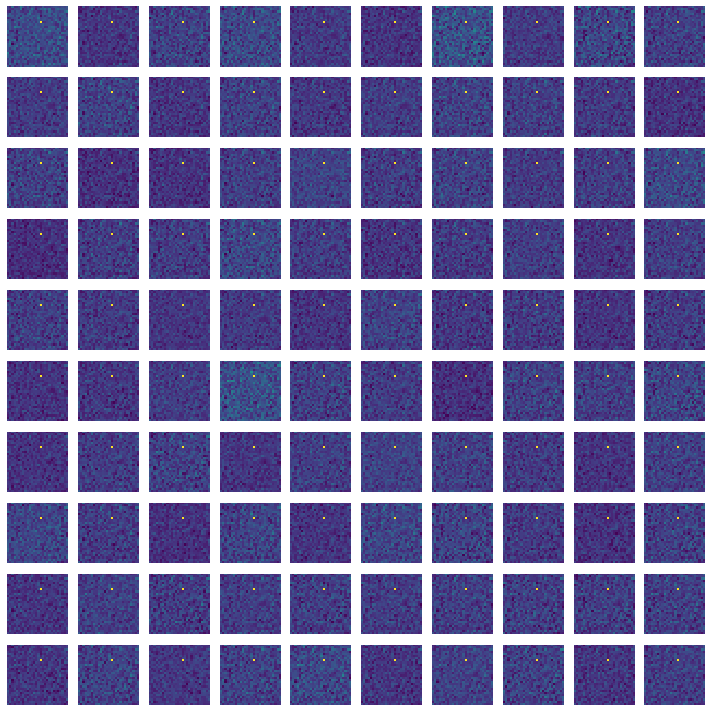

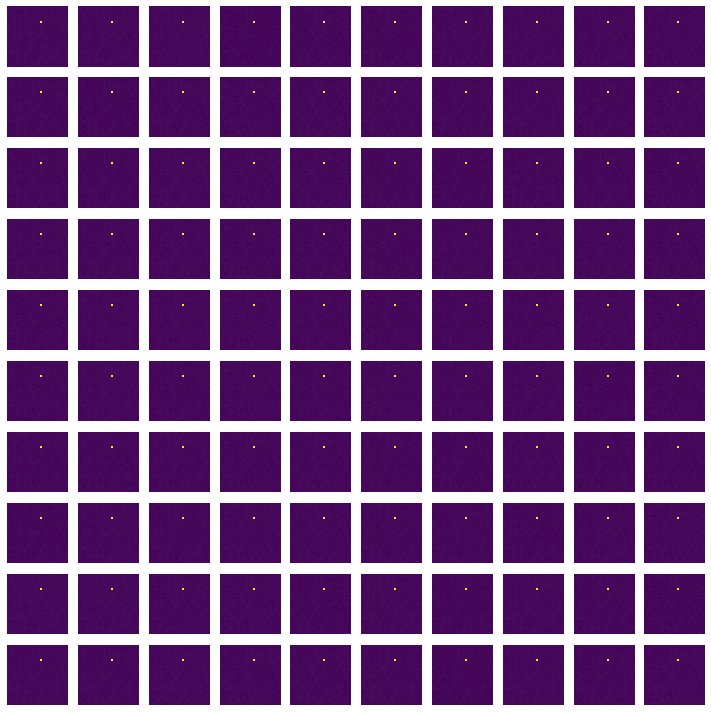

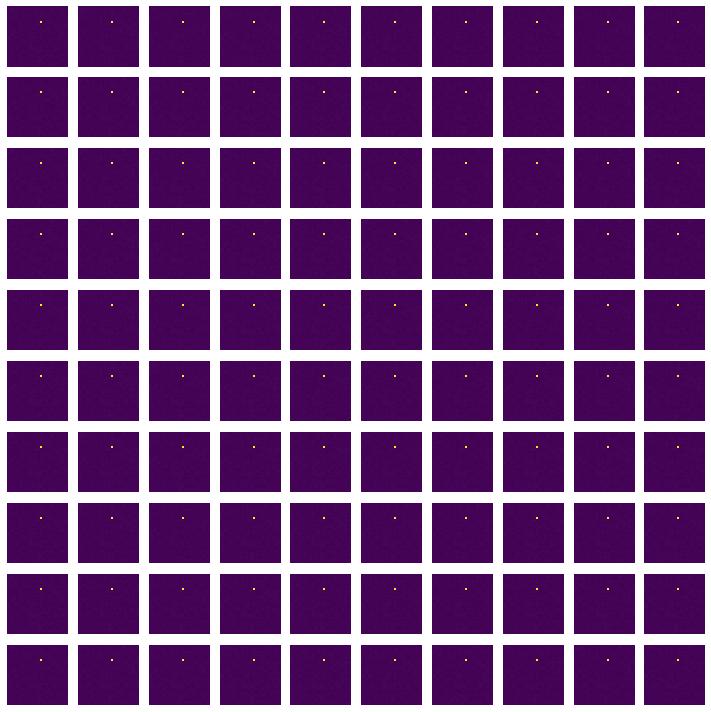

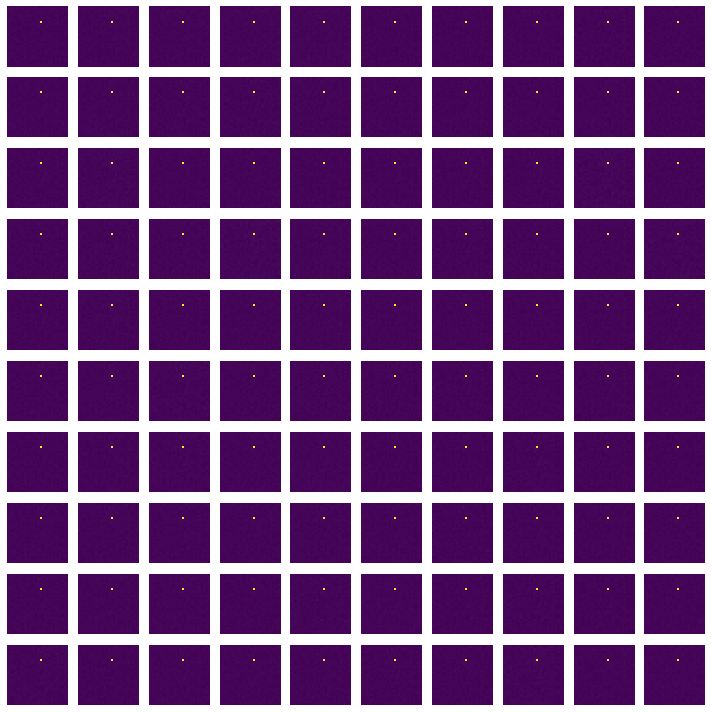

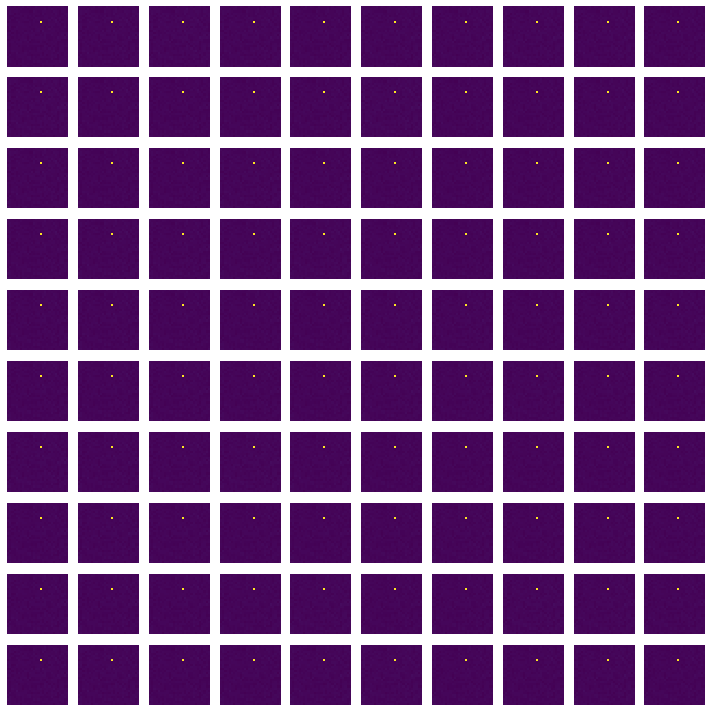

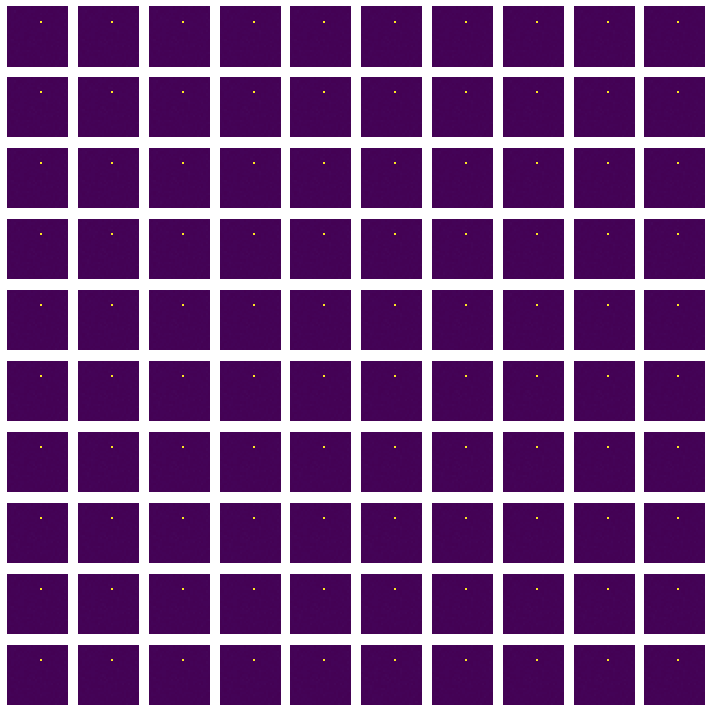

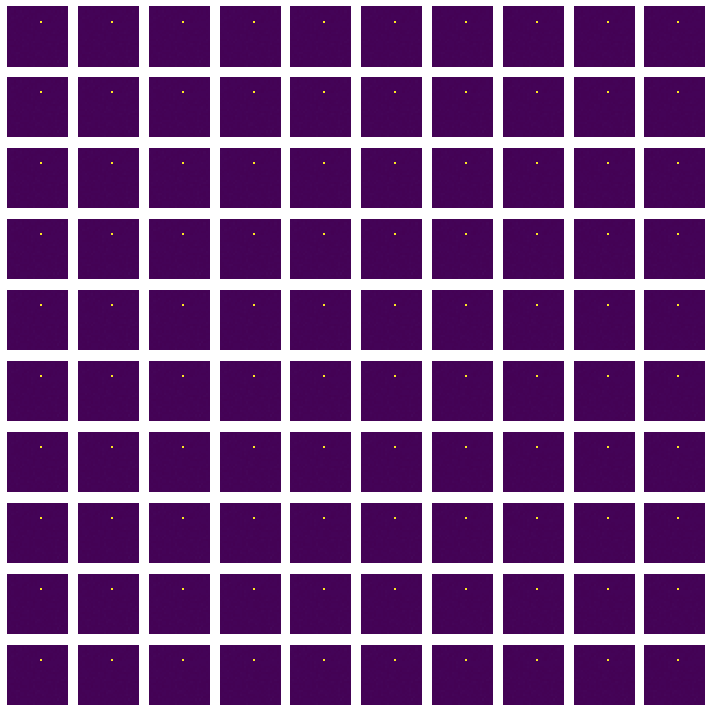

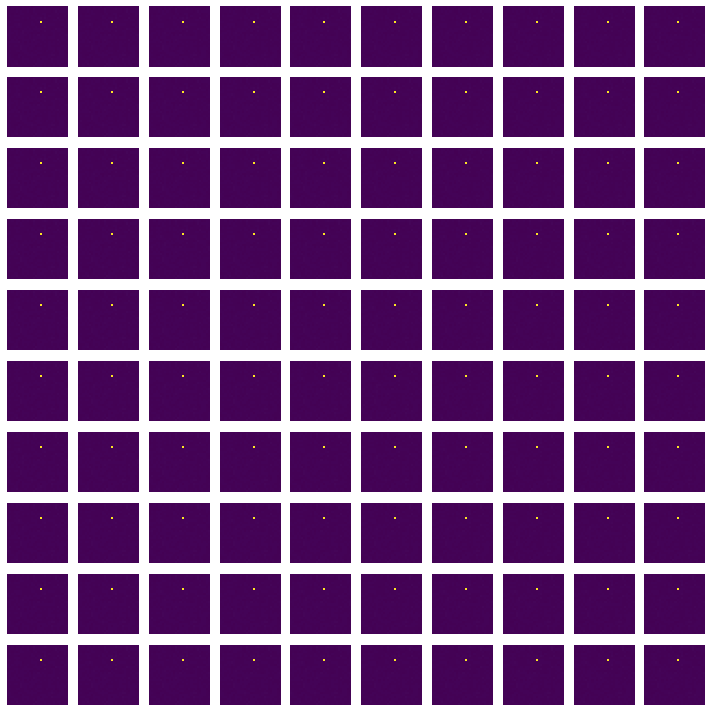

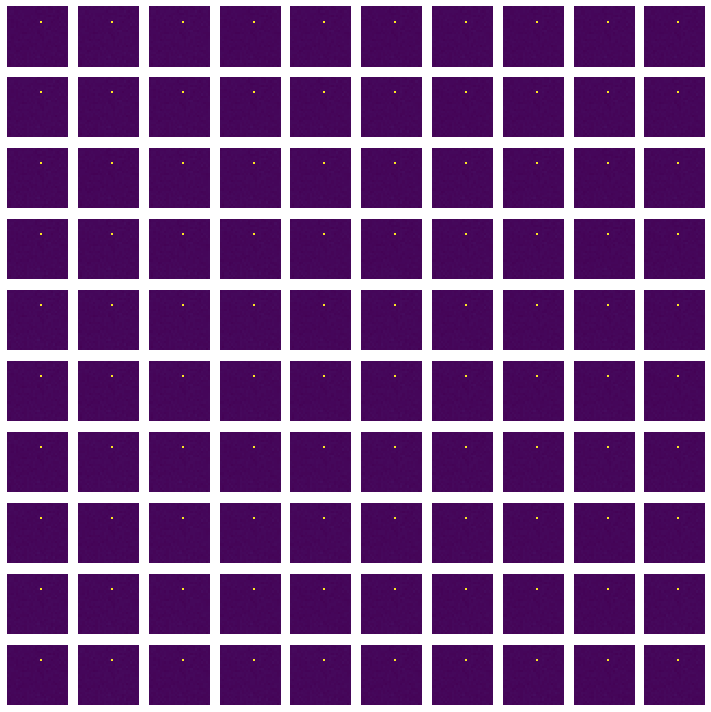

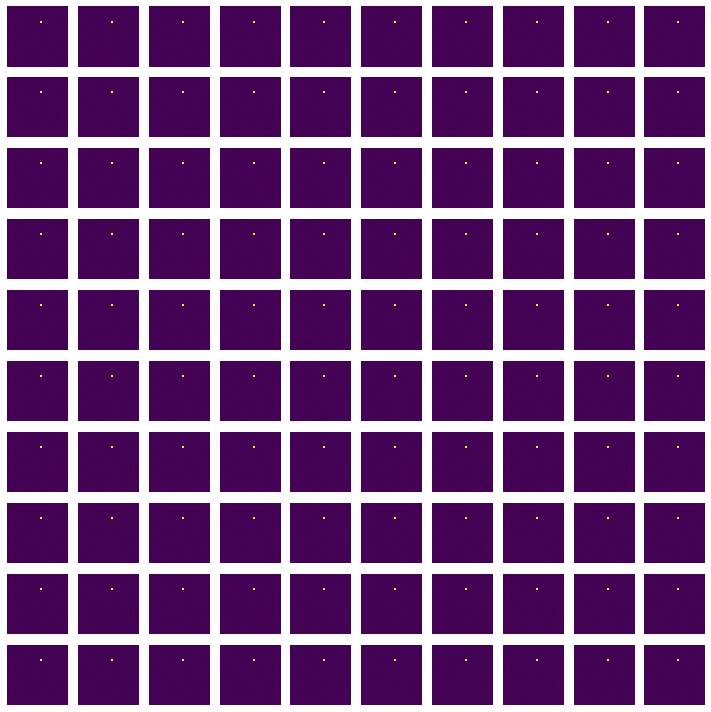

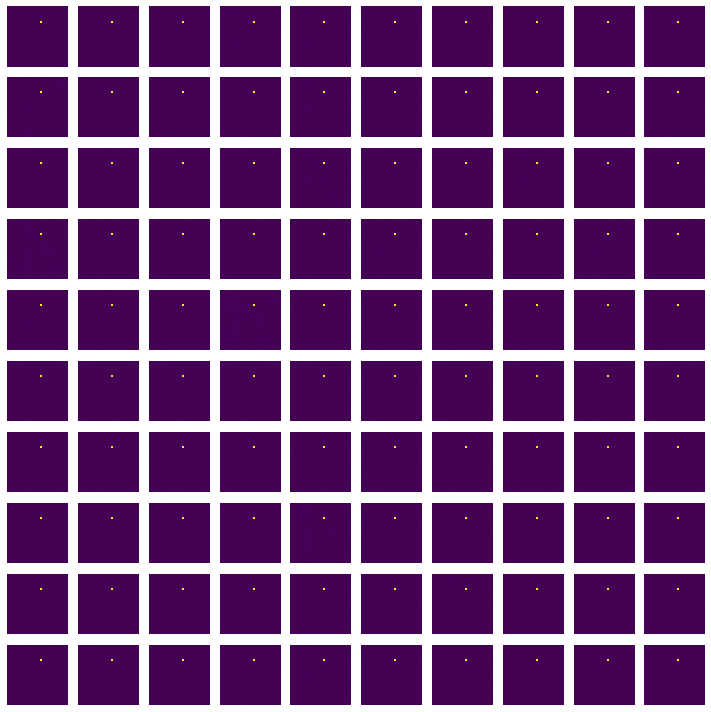

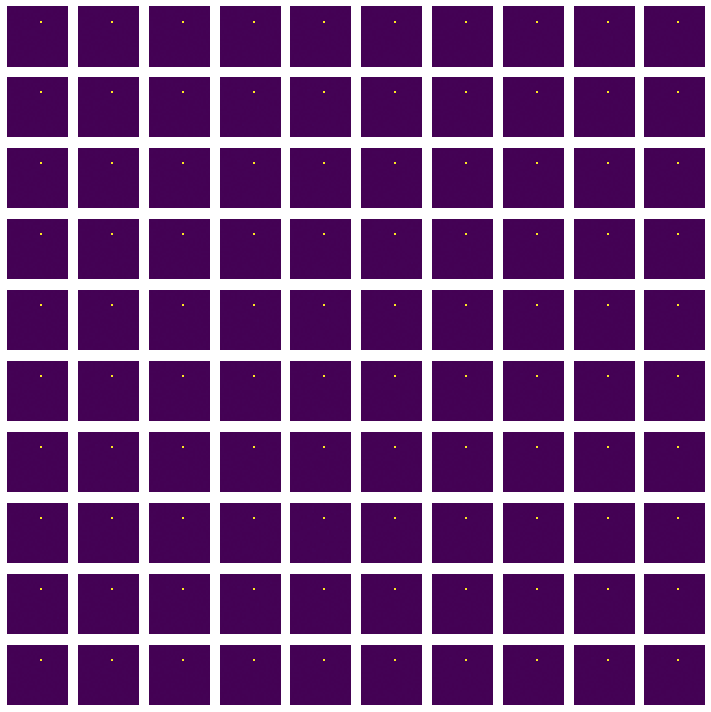

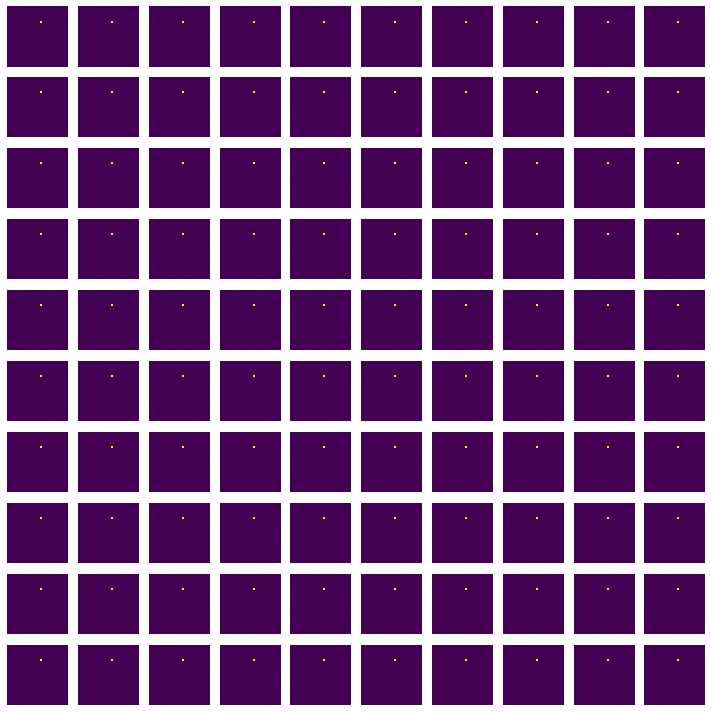

In [10]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    
    X_train_res, X_test_res = autoencoder_model(X_train, X_test)  # reconstruct original data by Autoencoder
    
    batch_count = X_train_res.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train_res[np.random.randint(low=0,high=X_train_res.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

training(400,128)